In [1]:
import os
import json
import glob
import datetime
import random
import re
import pprint
import warnings
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf

from matplotlib.patches import Patch
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, Callback
from imblearn.over_sampling import SMOTE

from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, ParameterSampler
from sklearn.metrics import (classification_report, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score, make_scorer,
                             confusion_matrix, roc_curve, auc)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter
from tqdm import tqdm

warnings.filterwarnings('ignore')


2024-05-02 21:09:37.772829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importing Data:

In [ ]:
# CRSS cleaned data:

crss_data = pd.read_csv('~/data/CRSS_Data/crss.csv')
crss_data.head(30)

,Unnamed: 0,PED_SAFETY,PED_SAFETY_IND,MAX_SEVERITY,MAX_SEVERITY_NM,SAFETYEQ,DISTRACTED,CROSSING,CASENUM,REGION,...,ALCOHOL,SPEEDING,TRAFFICWAY,TRAFFICWAY_NM,NUMBER_OF_LANES,SPEED_LIMIT,ROADWAY_ALIGNMENT,ROADWAY_ALIGNMENT_NM,TRAFFIC_CONTROL_DEVICE,TRAFFIC_CONTROL_DEVICE_NM
0,0,0,MINOR_NO_INJURY,1,Possible Injury,0,0,1,202204040976,2,...,0,9,0,Non-Trafficway,0,0.0,0.0,Non-Trafficway,0.0,No signal
1,1,1,SERIOUS_INJURY,3,Suspected Serious Injury,0,1,0,202204257294,3,...,9,0,1,Two-Way Not Divided,2,45.0,1.0,Straight,0.0,No signal
2,2,0,MINOR_NO_INJURY,2,Suspected Minor Injury,0,1,1,202204033237,3,...,0,0,1,Two-Way Not Divided,3,45.0,1.0,Straight,0.0,No signal
3,3,0,MINOR_NO_INJURY,2,Suspected Minor Injury,0,0,1,202204518258,2,...,9,0,1,Two-Way Not Divided,2,35.0,1.0,Straight,1.0,Traffic Signal
4,4,0,MINOR_NO_INJURY,2,Suspected Minor Injury,0,0,1,202204322904,3,...,0,0,1,Two-Way Not Divided,2,25.0,1.0,Straight,0.0,No signal
5,5,2,FATAL,4,Fatal,0,1,0,202203815126,2,...,1,0,1,Two-Way Not Divided,2,40.0,1.0,Straight,0.0,No signal
6,6,0,MINOR_NO_INJURY,1,Possible Injury,0,1,1,202204509073,3,...,0,0,1,Two-Way Not Divided,9,40.0,1.0,Straight,0.0,No signal
7,7,0,MINOR_NO_INJURY,2,Suspected Minor Injury,0,1,1,202204167067,3,...,0,0,1,Two-Way Not Divided,2,20.0,1.0,Straight,0.0,No signal
8,8,0,MINOR_NO_INJURY,2,Suspected Minor Injury,0,0,1,202204297732,3,...,0,0,1,Two-Way Not Divided,9,10.0,1.0,Straight,2.0,Traffic Sign
9,9,0,MINOR_NO_INJURY,2,Suspected Minor Injury,1,0,0,202204213899,3,...,0,0,1,Two-Way Not Divided,2,45.0,1.0,Straight,3.0,Other Signs


In [5]:
crss_data.shape

(27555, 48)

In [6]:
crss_data.dtypes

Unnamed: 0                     int64
PED_SAFETY                     int64
PED_SAFETY_IND                object
MAX_SEVERITY                   int64
MAX_SEVERITY_NM               object
SAFETYEQ                       int64
DISTRACTED                     int64
CROSSING                       int64
CASENUM                        int64
REGION                         int64
REGION_NM                     object
URBAN_CITY                     int64
URBAN_CITY_NM                 object
PEDESTRIAN_CYCLIST             int64
ALL_VHICLES_IN_CRASH           int64
PARKED_VEHICLES                int64
PERSON_IN_VEHICLE              int64
YEAR                           int64
MONTH                          int64
DAY_WEEK                       int64
WEEKEND                        int64
HARMFUL_EVENT                  int64
HARMFUL_EVENT_NM              object
COLLUSION                      int64
COLLUSION_NM                  object
JUNCTION                       int64
JUNCTION_NM                   object
I

# EDA:

#### Need to impute all NA values including hidden ones (some values are assigned a value of 99 to represent unknown) from the dataframe before modeling:

In [7]:
# Per column NA values
na_count_per_column = crss_data.isna().sum()

na_count_per_column

Unnamed: 0                      0
PED_SAFETY                      0
PED_SAFETY_IND                  0
MAX_SEVERITY                    0
MAX_SEVERITY_NM                 0
SAFETYEQ                        0
DISTRACTED                      0
CROSSING                        0
CASENUM                         0
REGION                          0
REGION_NM                       0
URBAN_CITY                      0
URBAN_CITY_NM                   0
PEDESTRIAN_CYCLIST              0
ALL_VHICLES_IN_CRASH            0
PARKED_VEHICLES                 0
PERSON_IN_VEHICLE               0
YEAR                            0
MONTH                           0
DAY_WEEK                        0
WEEKEND                         0
HARMFUL_EVENT                   0
HARMFUL_EVENT_NM                0
COLLUSION                       0
COLLUSION_NM                    0
JUNCTION                        0
JUNCTION_NM                     0
INTERSECTION_TYPE               0
INTERSECTION_TYPE_NM            0
CRASH_LOCATION

In [8]:
avg_spd_lim = crss_data['SPEED_LIMIT'].mean()
crss_data['SPEED_LIMIT'].fillna(avg_spd_lim, inplace=True)

In [9]:
avg_spd_lim

31.083492510304616

In [10]:
mode_rdwy_align = crss_data['ROADWAY_ALIGNMENT'].mode()[0]
crss_data['ROADWAY_ALIGNMENT'].fillna(mode_rdwy_align, inplace=True)

In [11]:
mode_rdwy_align

1.0

In [12]:
mode_traf_cntrl_dev = crss_data['TRAFFIC_CONTROL_DEVICE'].mode()[0]
crss_data['TRAFFIC_CONTROL_DEVICE'].fillna(mode_traf_cntrl_dev, inplace=True)

In [13]:
mode_traf_cntrl_dev

0.0

In [14]:
crss_data['SPEED_LIMIT'].isna().sum(), crss_data['ROADWAY_ALIGNMENT'].isna().sum(), crss_data['TRAFFIC_CONTROL_DEVICE'].isna().sum()

(0, 0, 0)

In [15]:
# Number of lanes values that are 9 are for unknown values
crss_data.loc[crss_data['NUMBER_OF_LANES'] == 9, 'NUMBER_OF_LANES'] = np.nan
mode_num_lanes = int(crss_data['NUMBER_OF_LANES'].mode()[0])
crss_data['NUMBER_OF_LANES'].fillna(mode_num_lanes, inplace=True)

In [16]:
mode_num_lanes

2

In [17]:
crss_data['NUMBER_OF_LANES'].value_counts()

NUMBER_OF_LANES
2.0    19153
3.0     2332
4.0     1892
0.0     1702
5.0     1463
1.0      433
6.0      399
7.0      181
Name: count, dtype: int64

In [18]:
np.unique(crss_data['NUMBER_OF_LANES'])

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [19]:
# COLLUSION column replacing values of 98 with 1 to make it a yes/no 1/0 variable:
crss_data.loc[crss_data['COLLUSION'] == 98, 'COLLUSION'] = 1


In [20]:
np.unique(crss_data['COLLUSION'])

array([0, 1])

In [21]:
# JUNCTION column values of 8 & 9 are unknown:

crss_data.loc[(crss_data['JUNCTION'] == 8) 
              | (crss_data['JUNCTION'] == 9), 'JUNCTION'] = np.nan

mode_junct = int(crss_data['JUNCTION'].mode()[0])

crss_data['JUNCTION'].fillna(mode_junct, inplace=True)


In [22]:
mode_junct

0

In [23]:
crss_data['JUNCTION'].value_counts()

JUNCTION
0.0    27134
1.0      421
Name: count, dtype: int64

In [24]:
np.unique(crss_data['JUNCTION'])

array([0., 1.])

In [25]:
# INTERSECTION_TYPE column: 
# Values of 98 & 99 are unknown,
# Values of 4, 5, 6, 7, 10, 11 are all “Other” and need to all be 
# set to 4 for understandability

crss_data.loc[(crss_data['INTERSECTION_TYPE'] == 98) 
              | (crss_data['INTERSECTION_TYPE'] == 99), 'INTERSECTION_TYPE'] = np.nan

mode_int_type = int(crss_data['INTERSECTION_TYPE'].mode()[0])
crss_data['INTERSECTION_TYPE'].fillna(mode_int_type, inplace=True)

int_type_same_vals = [4, 5, 6, 7, 10, 11]
crss_data.loc[crss_data['INTERSECTION_TYPE'].isin(int_type_same_vals), 
              'INTERSECTION_TYPE'] = 4


In [26]:
mode_int_type

1

In [27]:
crss_data['INTERSECTION_TYPE'].value_counts()

INTERSECTION_TYPE
1.0    14846
2.0     8809
3.0     3694
4.0      206
Name: count, dtype: int64

In [28]:
np.unique(crss_data['INTERSECTION_TYPE'])

array([1., 2., 3., 4.])

In [29]:
# CRASH_LOCATION column:
# Values of 98 & 99 unknown,
# Values of 5 & 12 are “other” and need to be same 

crss_data.loc[(crss_data['CRASH_LOCATION'] == 98) 
              | (crss_data['CRASH_LOCATION'] == 99), 'CRASH_LOCATION'] = np.nan

mode_crash_loc = int(crss_data['CRASH_LOCATION'].mode()[0])
crss_data['CRASH_LOCATION'].fillna(mode_crash_loc, inplace=True)

crash_loc_same_vals = [5, 12]
crss_data.loc[crss_data['CRASH_LOCATION'].isin(crash_loc_same_vals), 'CRASH_LOCATION'] = 5


In [30]:
mode_crash_loc

1

In [31]:
crss_data['CRASH_LOCATION'].value_counts()

CRASH_LOCATION
1.0     26057
4.0       598
2.0       494
7.0       183
5.0        94
3.0        46
6.0        40
11.0       33
8.0         7
10.0        3
Name: count, dtype: int64

In [32]:
np.unique(crss_data['CRASH_LOCATION'])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., 10., 11.])

In [33]:
# LIGHT_CONDITION column:
# Values of 6, 7, 8, 9 are unknown

crss_data.loc[(crss_data['LIGHT_CONDITION'] == 6) 
              | (crss_data['LIGHT_CONDITION'] == 7) 
              | (crss_data['LIGHT_CONDITION'] == 8) 
              | (crss_data['LIGHT_CONDITION'] == 9), 'LIGHT_CONDITION'] = np.nan

mode_lgt_cond = int(crss_data['LIGHT_CONDITION'].mode()[0])
crss_data['LIGHT_CONDITION'].fillna(mode_lgt_cond, inplace=True)


In [34]:
mode_lgt_cond

1

In [35]:
crss_data['LIGHT_CONDITION'].value_counts()

LIGHT_CONDITION
1.0    17342
3.0     6759
2.0     2255
5.0      812
4.0      387
Name: count, dtype: int64

In [36]:
np.unique(crss_data['LIGHT_CONDITION'])

array([1., 2., 3., 4., 5.])

In [37]:
# WEATHER column:
# Values of 98, 99 unknown
# Values of 6, 8 are other so make same number

crss_data.loc[(crss_data['WEATHER'] == 98) 
              | (crss_data['WEATHER'] == 99), 'WEATHER'] = np.nan

mode_wthr = int(crss_data['WEATHER'].mode()[0])
crss_data['WEATHER'].fillna(mode_wthr, inplace=True)

wthr_same_vals = [6, 8]
crss_data.loc[crss_data['WEATHER'].isin(wthr_same_vals), 'WEATHER'] = 6


In [38]:
mode_wthr

1

In [39]:
crss_data['WEATHER'].value_counts()

WEATHER
1.0     22410
10.0     2902
2.0      1973
4.0       154
5.0        76
6.0        17
3.0        13
12.0        6
11.0        4
Name: count, dtype: int64

In [40]:
np.unique(crss_data['WEATHER'])

array([ 1.,  2.,  3.,  4.,  5.,  6., 10., 11., 12.])

In [41]:
# ALCOHOL column:
# Value of 9 unknown

crss_data.loc[crss_data['ALCOHOL'] == 9, 'ALCOHOL'] = np.nan
mode_alc = int(crss_data['ALCOHOL'].mode()[0])   
crss_data['ALCOHOL'].fillna(mode_alc, inplace=True)


In [42]:
mode_alc

0

In [43]:
crss_data['ALCOHOL'].value_counts()

ALCOHOL
0.0    26057
1.0     1498
Name: count, dtype: int64

In [44]:
np.unique(crss_data['ALCOHOL'])

array([0., 1.])

In [45]:
# SPEEDING column:
# Value of 9 unknown

crss_data.loc[crss_data['SPEEDING'] == 9, 'SPEEDING'] = np.nan
mode_spd = int(crss_data['SPEEDING'].mode()[0])   
crss_data['SPEEDING'].fillna(mode_spd, inplace=True)

In [46]:
mode_spd

0

In [47]:
crss_data['SPEEDING'].value_counts()

SPEEDING
0.0    26888
1.0      667
Name: count, dtype: int64

In [48]:
np.unique(crss_data['SPEEDING'])

array([0., 1.])

In [49]:
# TRAFFICWAY column:
# Value of 9 unknown

crss_data.loc[crss_data['TRAFFICWAY'] == 9, 'TRAFFICWAY'] = np.nan
mode_tfc_wy = int(crss_data['TRAFFICWAY'].mode()[0])   
crss_data['TRAFFICWAY'].fillna(mode_tfc_wy, inplace=True)

In [50]:
mode_tfc_wy

1

In [51]:
crss_data['TRAFFICWAY'].value_counts()

TRAFFICWAY
1.0    20230
2.0     4512
0.0     1702
3.0      893
4.0      218
Name: count, dtype: int64

In [52]:
np.unique(crss_data['TRAFFICWAY'])

array([0., 1., 2., 3., 4.])

In [53]:
# Dropping unnecessry columns:

crss_data.drop(columns=['Unnamed: 0', 'CASENUM', 'MAX_SEVERITY',
                       'MAX_SEVERITY_NM', 'PEDESTRIAN_CYCLIST',
                       'HARMFUL_EVENT'], inplace=True)
crss_data.head()

,PED_SAFETY,PED_SAFETY_IND,SAFETYEQ,DISTRACTED,CROSSING,REGION,REGION_NM,URBAN_CITY,URBAN_CITY_NM,ALL_VHICLES_IN_CRASH,...,ALCOHOL,SPEEDING,TRAFFICWAY,TRAFFICWAY_NM,NUMBER_OF_LANES,SPEED_LIMIT,ROADWAY_ALIGNMENT,ROADWAY_ALIGNMENT_NM,TRAFFIC_CONTROL_DEVICE,TRAFFIC_CONTROL_DEVICE_NM
0,0,MINOR_NO_INJURY,0,0,1,2,Midwest,1,URBAN,1,...,0.0,0.0,0.0,Non-Trafficway,0.0,0.0,0.0,Non-Trafficway,0.0,No signal
1,1,SERIOUS_INJURY,0,1,0,3,South,1,URBAN,1,...,0.0,0.0,1.0,Two-Way Not Divided,2.0,45.0,1.0,Straight,0.0,No signal
2,0,MINOR_NO_INJURY,0,1,1,3,South,0,RURAL,1,...,0.0,0.0,1.0,Two-Way Not Divided,3.0,45.0,1.0,Straight,0.0,No signal
3,0,MINOR_NO_INJURY,0,0,1,2,Midwest,0,RURAL,1,...,0.0,0.0,1.0,Two-Way Not Divided,2.0,35.0,1.0,Straight,1.0,Traffic Signal
4,0,MINOR_NO_INJURY,0,0,1,3,South,1,URBAN,1,...,0.0,0.0,1.0,Two-Way Not Divided,2.0,25.0,1.0,Straight,0.0,No signal


In [54]:
# Identifying column types:
int_columns = crss_data.select_dtypes(include=['int64']).columns.tolist()
float_columns = crss_data.select_dtypes(include=['float64']).columns.tolist()
bool_columns = crss_data.select_dtypes(include=['bool']).columns.tolist()
str_columns = crss_data.select_dtypes(include=['object']).columns.tolist()

In [55]:
selected_columns = crss_data.select_dtypes(include=['int64', 'bool', 'float64']).columns.tolist()
quant_crss_data = crss_data.loc[:, selected_columns]
quant_crss_data.dtypes

PED_SAFETY                  int64
SAFETYEQ                    int64
DISTRACTED                  int64
CROSSING                    int64
REGION                      int64
URBAN_CITY                  int64
ALL_VHICLES_IN_CRASH        int64
PARKED_VEHICLES             int64
PERSON_IN_VEHICLE           int64
YEAR                        int64
MONTH                       int64
DAY_WEEK                    int64
WEEKEND                     int64
COLLUSION                   int64
JUNCTION                  float64
INTERSECTION_TYPE         float64
CRASH_LOCATION            float64
WORK_ZONE                   int64
LIGHT_CONDITION           float64
WEATHER                   float64
SCHOOL_BUS                  int64
INTERSTATE_HWY              int64
ALCOHOL                   float64
SPEEDING                  float64
TRAFFICWAY                float64
NUMBER_OF_LANES           float64
SPEED_LIMIT               float64
ROADWAY_ALIGNMENT         float64
TRAFFIC_CONTROL_DEVICE    float64
dtype: object

# Visualizations for the Report:

In [56]:
# Retrieve counts of unique values
unique_values, counts = np.unique(crss_data['DISTRACTED'], return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0: 14265
1: 13290


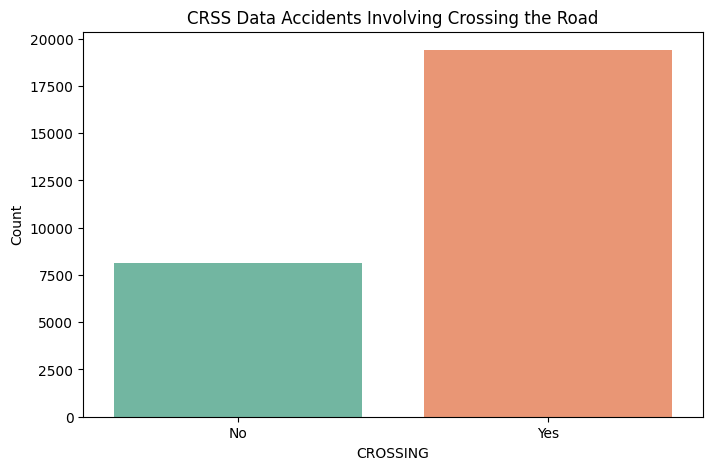

In [57]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=crss_data, x='CROSSING', order=[0, 1], palette='Set2')  
plt.title('CRSS Data Accidents Involving Crossing the Road')
plt.xlabel('CROSSING')
plt.ylabel('Count')

plt.xticks([0, 1], ['No', 'Yes'])

plt.show()


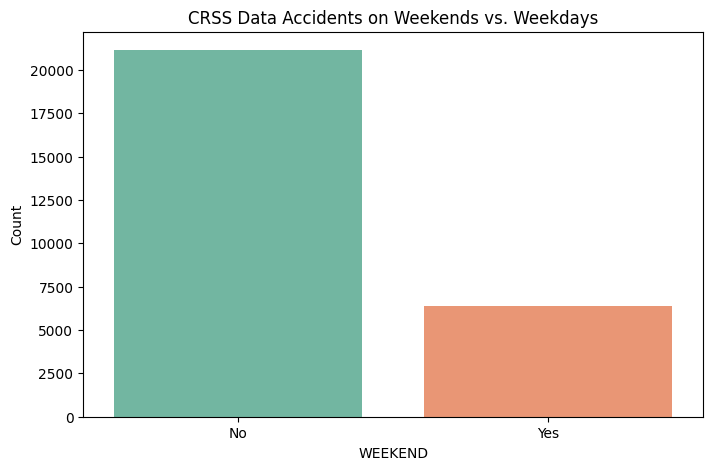

In [58]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=crss_data, x='WEEKEND', order=[0, 1], palette='Set2')  
plt.title('CRSS Data Accidents on Weekends vs. Weekdays')
plt.xlabel('WEEKEND')
plt.ylabel('Count')

plt.xticks([0, 1], ['No', 'Yes'])

plt.show()


In [59]:
# Get unique values and their counts
unique_values, counts = np.unique(crss_data['NUMBER_OF_LANES'], return_counts=True)

# Print frequency distribution
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0.0: 1702
1.0: 433
2.0: 19153
3.0: 2332
4.0: 1892
5.0: 1463
6.0: 399
7.0: 181


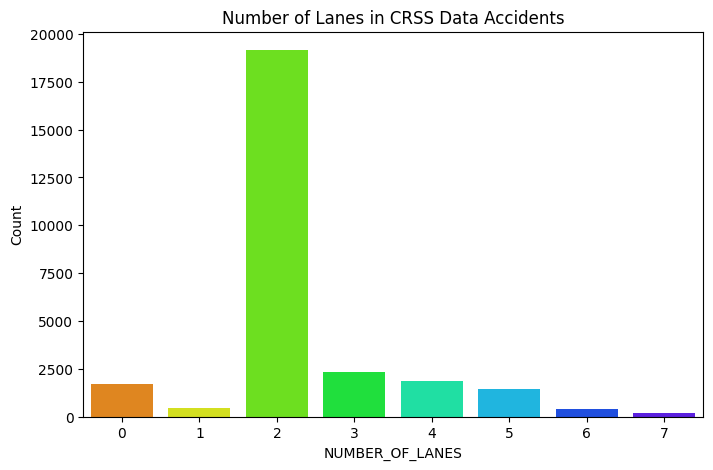

In [60]:
# Custom color palette
custom_palette = sns.color_palette("hsv", 10) 

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=crss_data, x='NUMBER_OF_LANES', order=range(8), palette=custom_palette) 
plt.title('Number of Lanes in CRSS Data Accidents')
plt.xlabel('NUMBER_OF_LANES')
plt.ylabel('Count')

plt.show()



In [61]:
# Get unique values and their counts
unique_values, counts = np.unique(crss_data['ALL_VHICLES_IN_CRASH'], return_counts=True)

# Print frequency distribution
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


1: 26986
2: 481
3: 67
4: 13
5: 4
6: 2
7: 1
9: 1


In [62]:
# Get unique values and their counts
unique_values, counts = np.unique(crss_data['PARKED_VEHICLES'], return_counts=True)

# Print frequency distribution
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0: 27260
1: 249
2: 33
3: 8
4: 3
6: 1
8: 1


In [63]:
# Get unique values and their counts
unique_values, counts = np.unique(crss_data['PERSON_IN_VEHICLE'], return_counts=True)

# Print frequency distribution
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


0: 102
1: 23135
2: 3087
3: 785
4: 290
5: 103
6: 34
7: 10
8: 4
9: 2
10: 1
13: 1
15: 1


In [64]:
# Get unique values and their counts
unique_values, counts = np.unique(crss_data['YEAR'], return_counts=True)

# Print frequency distribution
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")


2017: 4727
2018: 3765
2019: 4667
2020: 4791
2021: 4704
2022: 4901


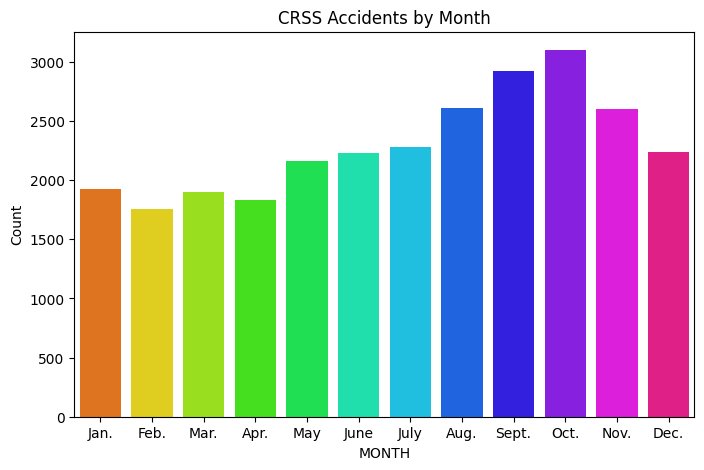

In [65]:
custom_palette = sns.color_palette("hsv", 12)

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=crss_data, x='MONTH', order=range(1, 13), palette=custom_palette) 
plt.title('CRSS Accidents by Month')
plt.xlabel('MONTH')
plt.ylabel('Count')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 
           ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 
            'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.'])
plt.show()



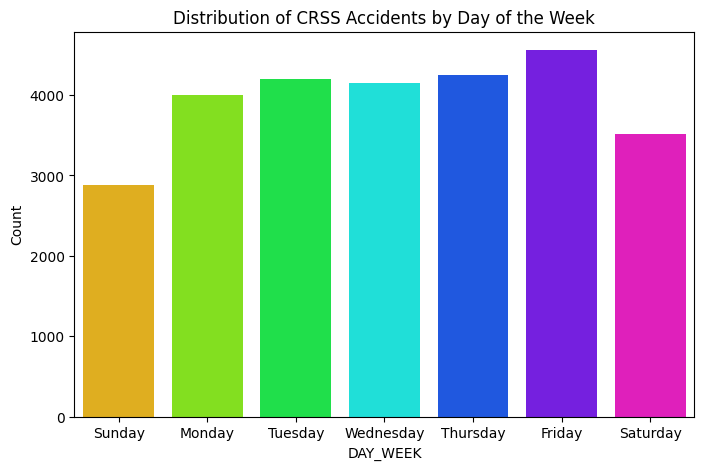

In [66]:
# Define a custom color palette with a unique color for each day of the week
custom_palette = sns.color_palette("hsv", 7)

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=crss_data, x='DAY_WEEK', order=[1, 2, 3, 4, 5, 6, 7], palette=custom_palette) 
plt.title('Distribution of CRSS Accidents by Day of the Week')
plt.xlabel('DAY_WEEK')
plt.ylabel('Count')

# Set custom labels for x-axis ticks
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

plt.show()



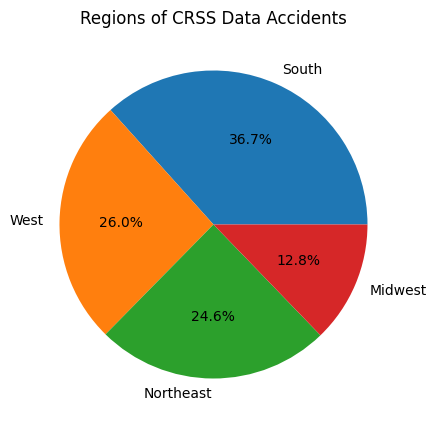

In [67]:
# Define the numeric to category mapping
region_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West'}

# Mapping
crss_data['REGION'] = crss_data['REGION'].map(region_mapping)

plt.figure(figsize=(8, 5))
region_counts = crss_data['REGION'].value_counts()
region_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Regions of CRSS Data Accidents')
plt.ylabel('')
plt.show()


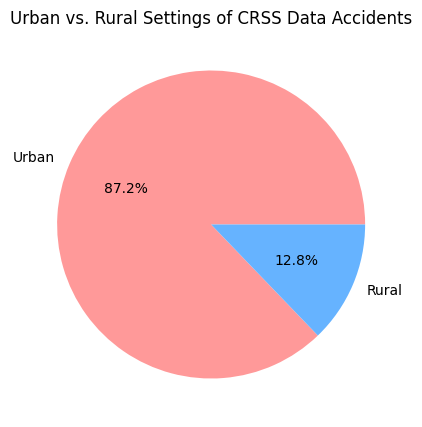

In [68]:
# Define the numeric to category mapping
URBAN_CITY_mapping = {0: 'Rural', 1: 'Urban'}

# Mapping
crss_data['URBAN_CITY'] = crss_data['URBAN_CITY'].map(URBAN_CITY_mapping)

custom_colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 5))
URBAN_CITY_counts = crss_data['URBAN_CITY'].value_counts()
URBAN_CITY_counts.plot(kind='pie', autopct='%1.1f%%', colors=custom_colors)
plt.title('Urban vs. Rural Settings of CRSS Data Accidents')
plt.ylabel('')
plt.show()


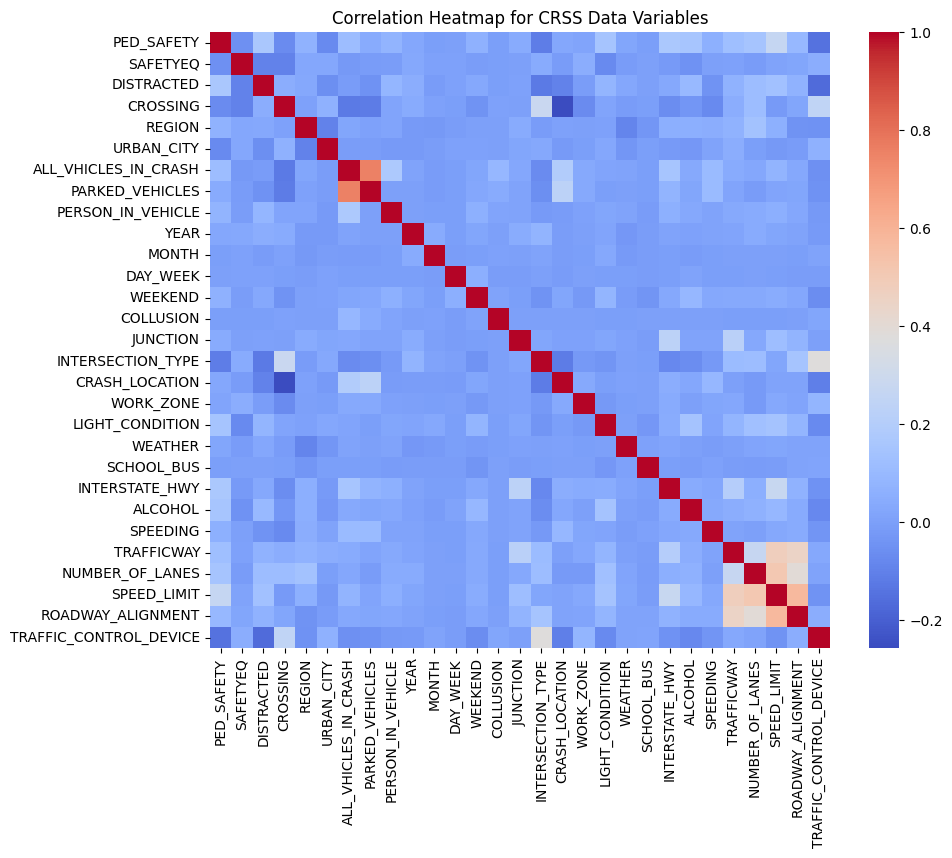

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(quant_crss_data.corr(), annot=False, cmap='coolwarm')

plt.title('Correlation Heatmap for CRSS Data Variables')
plt.show()



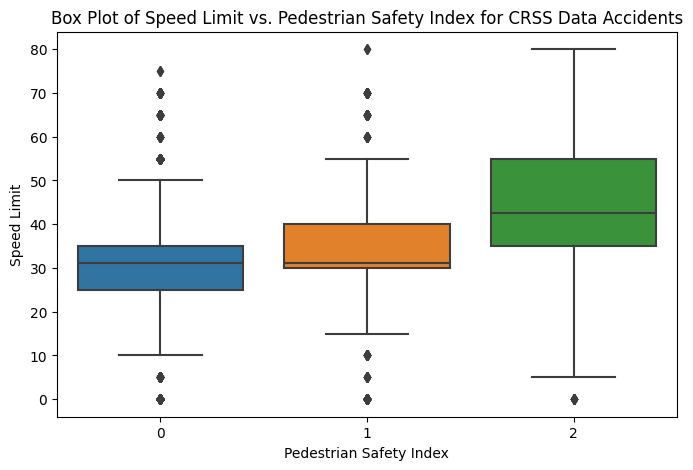

In [70]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='PED_SAFETY', y='SPEED_LIMIT', data=crss_data)
plt.title('Box Plot of Speed Limit vs. Pedestrian Safety Index for CRSS Data Accidents')
plt.xlabel('Pedestrian Safety Index')
plt.ylabel('Speed Limit')
plt.show()


# Train-Test Split for All Models:

In [71]:
X = quant_crss_data.loc[:, ~(quant_crss_data.columns.isin(['PED_SAFETY']))]

# X = quant_crss_data.loc[:, ~(quant_crss_data.columns.isin(['PED_SAFETY', 'PEDESTRIAN_CYCLIST', 
#                                                                        'HARMFUL_EVENT']))]

y = quant_crss_data.loc[:,'PED_SAFETY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [72]:
X.shape, type(X)

((27555, 28), pandas.core.frame.DataFrame)

In [73]:
y.shape, type(y)

((27555,), pandas.core.series.Series)

In [74]:
X_train.shape, type(X_train)

((20666, 28), pandas.core.frame.DataFrame)

In [75]:
X_test.shape, type(X_test)

((6889, 28), pandas.core.frame.DataFrame)

In [76]:
y_train.shape, type(y_train)

((20666,), pandas.core.series.Series)

In [77]:
np.unique(y_train)

array([0, 1, 2])

In [78]:
y_test.shape, type(y_test)

((6889,), pandas.core.series.Series)

# Scaling the Quantitative Columns Only:

In [79]:
# Initialize the scaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Scale both the training and the testing data 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled numpy arrays to dfs
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [80]:
X_train_scaled_df.head()

,SAFETYEQ,DISTRACTED,CROSSING,REGION,URBAN_CITY,ALL_VHICLES_IN_CRASH,PARKED_VEHICLES,PERSON_IN_VEHICLE,YEAR,MONTH,...,WEATHER,SCHOOL_BUS,INTERSTATE_HWY,ALCOHOL,SPEEDING,TRAFFICWAY,NUMBER_OF_LANES,SPEED_LIMIT,ROADWAY_ALIGNMENT,TRAFFIC_CONTROL_DEVICE
0,-0.314119,1.041709,-1.540971,0.322185,0.383193,-0.127543,-0.088689,-0.347976,0.246862,-1.187418,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,1.292633,0.568570,-1.370774,0.1024,0.568523
1,-0.314119,-0.959961,0.648941,1.217114,0.383193,-0.127543,-0.088689,-0.347976,-1.493720,-1.485270,...,-0.381858,-0.066504,-0.116345,-0.240841,6.337770,-0.306598,-0.283008,0.333348,0.1024,1.909591
2,-0.314119,1.041709,0.648941,-0.572744,0.383193,-0.127543,-0.088689,-0.347976,-1.493720,1.493255,...,-0.020956,-0.066504,-0.116345,-0.240841,-0.157784,1.292633,0.568570,1.185408,0.1024,-0.772545
3,-0.314119,-0.959961,-1.540971,-1.467674,0.383193,-0.127543,-0.088689,-0.347976,0.246862,0.003992,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,-0.283008,-0.000363,0.1024,-0.772545
4,-0.314119,1.041709,0.648941,1.217114,0.383193,-0.127543,-0.088689,-0.347976,1.407250,-0.293860,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,-0.283008,0.759378,0.1024,0.568523


In [81]:
X_test_scaled_df.head()

,SAFETYEQ,DISTRACTED,CROSSING,REGION,URBAN_CITY,ALL_VHICLES_IN_CRASH,PARKED_VEHICLES,PERSON_IN_VEHICLE,YEAR,MONTH,...,WEATHER,SCHOOL_BUS,INTERSTATE_HWY,ALCOHOL,SPEEDING,TRAFFICWAY,NUMBER_OF_LANES,SPEED_LIMIT,ROADWAY_ALIGNMENT,TRAFFIC_CONTROL_DEVICE
0,-0.314119,-0.959961,-1.540971,0.322185,0.383193,-0.127543,-0.088689,-0.347976,-0.333332,1.195402,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,0.568570,-1.370774,0.1024,1.909591
1,-0.314119,1.041709,0.648941,-0.572744,0.383193,-0.127543,-0.088689,1.242662,-1.493720,-0.889565,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,-0.283008,-0.092683,0.1024,-0.772545
2,3.183504,1.041709,-1.540971,0.322185,0.383193,-0.127543,-0.088689,-0.347976,1.407250,1.195402,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,1.292633,-0.283008,0.333348,0.1024,-0.772545
3,3.183504,-0.959961,-1.540971,-0.572744,0.383193,-0.127543,-0.088689,-0.347976,0.827056,1.493255,...,-0.020956,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,1.420149,0.759378,0.1024,-0.772545
4,-0.314119,-0.959961,-1.540971,1.217114,-2.609651,-0.127543,-0.088689,-0.347976,-0.333332,1.493255,...,2.866255,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,1.420149,-0.092683,0.1024,-0.772545


# Non-SMOTE Random Forest Model:

In [82]:
np.unique(y_train)

array([0, 1, 2])

In [ ]:
def train_best_model(X_train, y_train, X_test, y_test, num_iters=10, num_folds_cv=5):
    import joblib
    from tqdm import tqdm
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import RandomizedSearchCV

    model_file = "non_smote_best_model_rf.joblib"
    
    if os.path.exists(model_file):
        print("Loading the best model")
        rand_search_rf = joblib.load(model_file)
        best_params_rf = rand_search_rf.best_params_
        best_rf_model = rand_search_rf.best_estimator_
    else:
        param_distributions_rf = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

        rf = RandomForestClassifier(random_state=42)
        rand_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions_rf, n_iter=num_iters, cv=num_folds_cv)

        with tqdm(total=num_iters * num_folds_cv) as pbar:
            rand_search_rf.fit(X_train, y_train)
            pbar.update(num_folds_cv*num_iters)

        best_params_rf = rand_search_rf.best_params_
        best_rf_model = rand_search_rf.best_estimator_

        joblib.dump(rand_search_rf, model_file)
        print("Saved the best model")

    return best_rf_model, best_params_rf



In [84]:
# Calling the function
best_rf_model, best_params_rf = train_best_model(X_train_scaled_df, y_train, X_test_scaled_df, y_test)

Loading the best model


In [85]:
best_params_rf

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None}

In [87]:
# Feature Importance Plot Values:
impts = best_rf_model.feature_importances_

feature_names = X_train_scaled_df.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


SPEED_LIMIT: 0.15417437260729272
MONTH: 0.10566258652434576
LIGHT_CONDITION: 0.09893681450024014
YEAR: 0.07958227648727204
DAY_WEEK: 0.07845551650677116
NUMBER_OF_LANES: 0.055220444223480644
REGION: 0.052467571698061904
TRAFFIC_CONTROL_DEVICE: 0.04458690778647563
DISTRACTED: 0.04326607456170005
INTERSECTION_TYPE: 0.036176800881067075
TRAFFICWAY: 0.03255918626359508
ALCOHOL: 0.02949744182441757
PERSON_IN_VEHICLE: 0.028074866405459007
WEATHER: 0.028017042001771714
CROSSING: 0.023418742014432167
URBAN_CITY: 0.018934355750750788
WEEKEND: 0.018400959122478567
CRASH_LOCATION: 0.014980622379254644
INTERSTATE_HWY: 0.013492377636884583
ALL_VHICLES_IN_CRASH: 0.011317487978667084
ROADWAY_ALIGNMENT: 0.009736064935454031
SAFETYEQ: 0.009587861021798368
SPEEDING: 0.006502575705883928
PARKED_VEHICLES: 0.0031235646419716244
JUNCTION: 0.002148842627852887
WORK_ZONE: 0.0010345879903806273
SCHOOL_BUS: 0.0006440559222403195
COLLUSION: 0.0


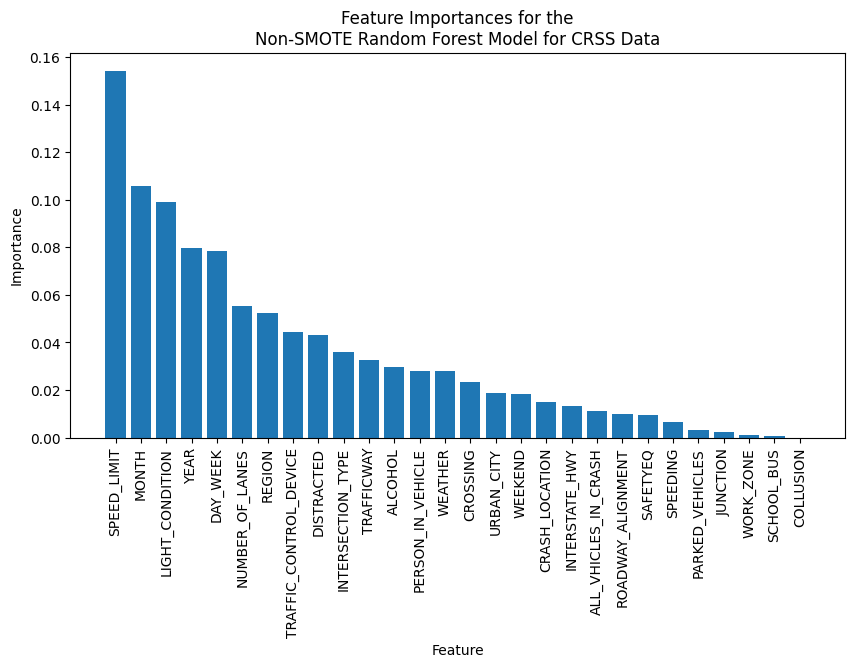

In [88]:
impts = best_rf_model.feature_importances_
idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances for the\nNon-SMOTE Random Forest Model for CRSS Data")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs], rotation=90)  # Make labels vertical
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


In [89]:
# Find predictions for the test data using the best model
preds_rf = best_rf_model.predict(X_test_scaled_df)

acc_rf = accuracy_score(y_test, preds_rf)
print("Best Non-SMOTE Random Forest Model's Test Accuracy:", acc_rf)

Best Non-SMOTE Random Forest Model's Test Accuracy: 0.7976484250254028


In [90]:
# Confusion Matrix:

conf_mat_rf = confusion_matrix(y_test, preds_rf)

# Empty sens and spec lists
sens_list = []
spec_list = []

# Find sensitivity and specificity for each class, where "positive" means equal to 
# the class and "negative" means not equal to the class
for i in range(conf_mat_rf.shape[0]):
    TP = conf_mat_rf[i, i]
    FN = np.sum(conf_mat_rf[i, :]) - TP
    FP = np.sum(conf_mat_rf[:, i]) - TP
    TN = np.sum(conf_mat_rf) - (TP + FN + FP)
    
    sens = TP / (TP + FN)
    spec = TN / (TN + FP)
    
    sens_list.append(sens)
    spec_list.append(spec)

# Print out classes' sens and spec values
for i, (sens, spec) in enumerate(zip(sens_list, spec_list)):
    print(f"Class {i}: Sensitivity = {sens}, Specificity = {spec}")


Class 0: Sensitivity = 0.9934012066365008, Specificity = 0.16782334384858044
Class 1: Sensitivity = 0.11243072050673, Specificity = 0.9934233913970849
Class 2: Sensitivity = 0.2608695652173913, Specificity = 0.9942134917009289


In [91]:
print("Classification Report Non-SMOTE Random Forest Model:\n")
print(classification_report(y_test, preds_rf))


Classification Report Non-SMOTE Random Forest Model:

              precision    recall  f1-score   support

           0       0.80      0.99      0.89      5304
           1       0.79      0.11      0.20      1263
           2       0.69      0.26      0.38       322

    accuracy                           0.80      6889
   macro avg       0.76      0.46      0.49      6889
weighted avg       0.79      0.80      0.74      6889



In [92]:
conf_mat_rf = confusion_matrix(y_test, preds_rf)

In [93]:
print(conf_mat_rf)

[[5269   20   15]
 [1098  142   23]
 [ 221   17   84]]


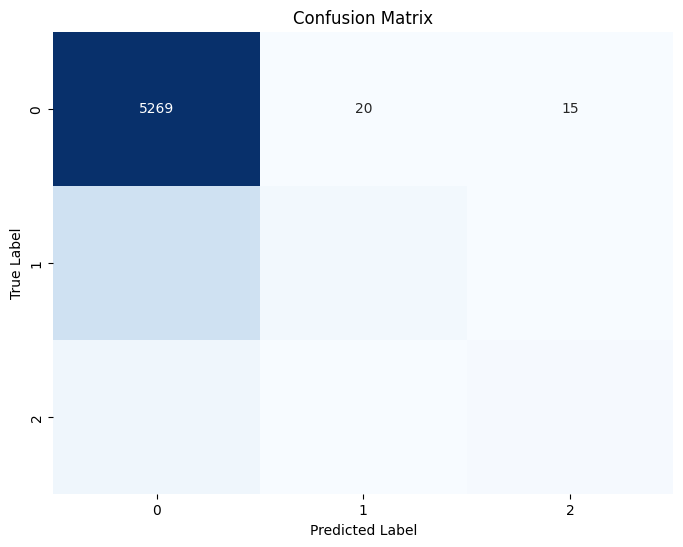

In [94]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Non-SMOTE Feed Forward Neural Network Model:

In [95]:
np.unique(y_train)

array([0, 1, 2])

In [96]:
np.unique(y_test)

array([0, 1, 2])

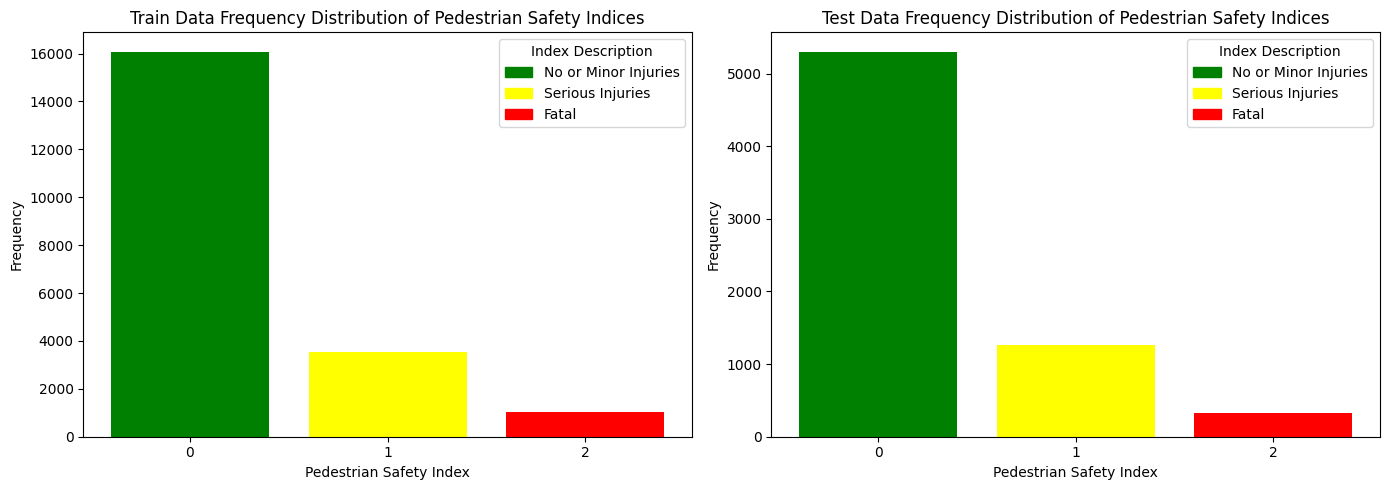

In [97]:
def plot_side_by_side(y_train, y_test):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    color_map = {0: 'green', 1: 'yellow', 2: 'red'}
    
    # Plot y_train
    unique_indices_train, index_counts_train = np.unique(y_train, return_counts=True)
    colors_train = [color_map[i] for i in unique_indices_train]
    axes[0].bar(unique_indices_train, index_counts_train, color=colors_train)
    axes[0].set_xlabel('Pedestrian Safety Index')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Train Data Frequency Distribution of Pedestrian Safety Indices')
    axes[0].set_xticks(unique_indices_train)
    labels = ['No or Minor Injuries', 'Serious Injuries', 'Fatal']
    handles_train = [plt.Rectangle((0,0),1,1, color=color_map[i]) for i in range(len(labels))]
    axes[0].legend(handles_train, labels, title="Index Description")
    
    # Plot y_test
    unique_indices_test, index_counts_test = np.unique(y_test, return_counts=True)
    colors_test = [color_map[i] for i in unique_indices_test]
    axes[1].bar(unique_indices_test, index_counts_test, color=colors_test)
    axes[1].set_xlabel('Pedestrian Safety Index')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Test Data Frequency Distribution of Pedestrian Safety Indices')
    axes[1].set_xticks(unique_indices_test)
    handles_test = [plt.Rectangle((0,0),1,1, color=color_map[i]) for i in range(len(labels))]
    axes[1].legend(handles_test, labels, title="Index Description")
    
    plt.tight_layout()
    plt.show()

plot_side_by_side(y_train, y_test)

In [98]:
X_train_scaled_df.shape, y_train.shape

((20666, 28), (20666,))

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def train_best_nn_model(X_train, y_train, X_test, y_test, inp_shp, num_epochs=50, batch_size=32):
    
    model_file = "non_smote_best_model_nn.h5"
    
    if os.path.exists(model_file):
        print("Loading the neural network")
        best_nn_model = load_model(model_file)
        # Accessing model configuration:
        optimizer_config = best_nn_model.optimizer.get_config()
        print("Optimizer:", optimizer_config)
    else:
        nn_model = Sequential([
            Dense(32, activation='relu', input_shape=(inp_shp,)),
            BatchNormalization(),
            Dense(3, activation='softmax') # 3 possible output class values of 0, 1, or 2
        ])
        
        nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        early_stop_monitor = EarlyStopping(
            monitor='val_loss',
            patience=5, # Stop training when no improvement in validation loss for 5 consecutive epochs
            verbose=1
        )

        nn_model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, 
                     validation_split=0.2, callbacks=[early_stop_monitor])

        nn_model.save(model_file)
        print("Saved a neural network model to file.")

        best_nn_model = nn_model
        optimizer_config = best_nn_model.optimizer.get_config()

    return best_nn_model, optimizer_config


In [100]:
# Call the function
best_nn_model, optimizer_config = train_best_nn_model(X_train_scaled_df, y_train, 
                                                      X_test_scaled_df, y_test, 
                                                      inp_shp=28)



Loading the neural network


2024-04-29 01:23:59.734882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Optimizer: {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


If the softmax function is used in the output layer, Keras' predict() method outputs probabilites corresponding to each class instead of the class labels. So, these probabilities need to be changed to class labels by choosing the class that has the largest probability value for every prediction.

Because the accuracy_score() function in scikit-learn wants y_test and preds_nn, these both have to either both contain labels or both contain probabilities.


In [101]:
preds_nn_prob = best_nn_model.predict(X_test_scaled_df)

# Change probabilities to labels
preds_nn = np.argmax(preds_nn_prob, axis=1)

acc_nn = accuracy_score(y_test, preds_nn)
print("Non-SMOTE Neural Network Test Accuracy:", acc_nn)


216/216 [==============================] - 0s 752us/step
Non-SMOTE Neural Network Test Accuracy: 0.7774713311075628


In [102]:
nn_classif_report = classification_report(y_test, preds_nn)
print('Classification Report for the Non-SMOTE Feed Forward Neural Network Model:')
print(nn_classif_report)

Classification Report for the Non-SMOTE Feed Forward Neural Network Model:
              precision    recall  f1-score   support

           0       0.80      0.98      0.88      5304
           1       0.43      0.08      0.14      1263
           2       0.49      0.25      0.33       322

    accuracy                           0.78      6889
   macro avg       0.57      0.44      0.45      6889
weighted avg       0.72      0.78      0.72      6889



In [103]:
best_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                928       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,155
Trainable params: 1,091
Non-trainable params: 64
_________________________________________________________________


In [104]:
conf_mat_nn = confusion_matrix(y_test, preds_nn)

In [105]:
print(conf_mat_nn)

[[5173  101   30]
 [1105  102   56]
 [ 207   34   81]]


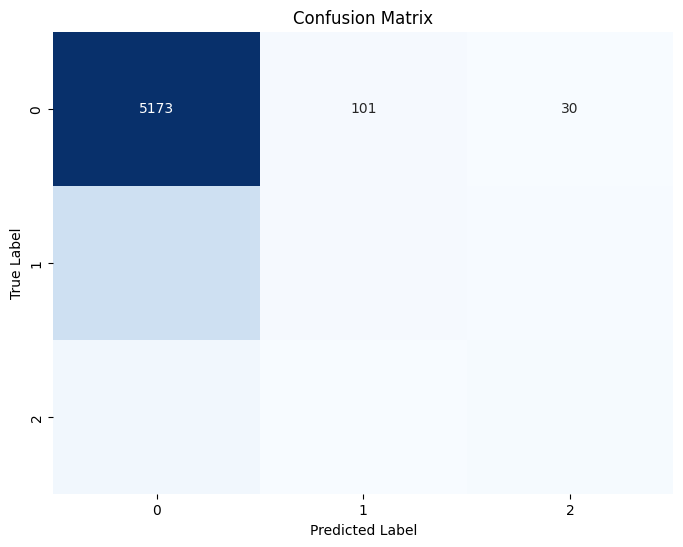

In [106]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_nn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Applying SMOTE to the Train Data:

In [107]:
# Initialize SMOTE with a smaller number of k_neighbors
# k_neighbors must be < the lowest class count - 1
smote = SMOTE(k_neighbors=min([y_train.value_counts().min() - 1, 5]))  

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_df, y_train)
X_train_smote_df = pd.DataFrame(X_train_smote, columns=X_train_scaled_df.columns)
X_train_smote_df.head()

,SAFETYEQ,DISTRACTED,CROSSING,REGION,URBAN_CITY,ALL_VHICLES_IN_CRASH,PARKED_VEHICLES,PERSON_IN_VEHICLE,YEAR,MONTH,...,WEATHER,SCHOOL_BUS,INTERSTATE_HWY,ALCOHOL,SPEEDING,TRAFFICWAY,NUMBER_OF_LANES,SPEED_LIMIT,ROADWAY_ALIGNMENT,TRAFFIC_CONTROL_DEVICE
0,-0.314119,1.041709,-1.540971,0.322185,0.383193,-0.127543,-0.088689,-0.347976,0.246862,-1.187418,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,1.292633,0.568570,-1.370774,0.1024,0.568523
1,-0.314119,-0.959961,0.648941,1.217114,0.383193,-0.127543,-0.088689,-0.347976,-1.493720,-1.485270,...,-0.381858,-0.066504,-0.116345,-0.240841,6.337770,-0.306598,-0.283008,0.333348,0.1024,1.909591
2,-0.314119,1.041709,0.648941,-0.572744,0.383193,-0.127543,-0.088689,-0.347976,-1.493720,1.493255,...,-0.020956,-0.066504,-0.116345,-0.240841,-0.157784,1.292633,0.568570,1.185408,0.1024,-0.772545
3,-0.314119,-0.959961,-1.540971,-1.467674,0.383193,-0.127543,-0.088689,-0.347976,0.246862,0.003992,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,-0.283008,-0.000363,0.1024,-0.772545
4,-0.314119,1.041709,0.648941,1.217114,0.383193,-0.127543,-0.088689,-0.347976,1.407250,-0.293860,...,-0.381858,-0.066504,-0.116345,-0.240841,-0.157784,-0.306598,-0.283008,0.759378,0.1024,0.568523


# SMOTE Random Forest Model:

In [108]:
np.unique(y_train_smote)

array([0, 1, 2])

In [109]:
y_train_smote.value_counts()

PED_SAFETY
0    16084
2    16084
1    16084
Name: count, dtype: int64

In [110]:
def train_best_model(X_train_smote, y_train_smote, X_test, y_test, num_iters=10, num_folds_cv=5):
    model_file = "smote_best_model_rf.joblib"

    if os.path.exists(model_file):
        print("Loading the best model")
        rand_search_rf = joblib.load(model_file)
    else:
        # Parameters to experiment with
        param_distributions_rf = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2']
        }

        rf = RandomForestClassifier(random_state=42)

        # Set scoring metrics
        scoring_metrics = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1': make_scorer(f1_score, average='weighted')
        }

        # Conduct randomized search cross-validation
        rand_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions_rf,
                                            n_iter=num_iters, cv=num_folds_cv, scoring=scoring_metrics, refit='accuracy')

        with tqdm(total=num_iters * num_folds_cv) as pbar:
            rand_search_rf.fit(X_train_smote, y_train_smote)
            pbar.update(num_folds_cv*num_iters)

        joblib.dump(rand_search_rf, model_file)
        print("Saved the best model")

    # Retrieve the best estimator and parameters
    best_params_rf = rand_search_rf.best_params_
    best_rf_model = rand_search_rf.best_estimator_

    cv_results = rand_search_rf.cv_results_
    print(cv_results)

    return best_rf_model, best_params_rf

best_rf_model, best_params_rf = train_best_model(X_train_smote, y_train_smote, X_test, y_test)


100%|███████████████████████████████████████████| 50/50 [06:32<00:00,  7.85s/it]


Saved the best model
{'mean_fit_time': array([11.63933487,  3.62332301,  2.88125658,  7.99558492,  7.74618516,
        8.72708478,  8.76733623, 13.37990556,  4.93058176,  2.30980568]), 'std_fit_time': array([1.8855478 , 0.11232654, 0.19928472, 0.47437035, 0.33552579,
       0.43014955, 0.42964472, 1.12505799, 0.15102116, 0.10322077]), 'mean_score_time': array([0.53647223, 0.13900223, 0.10398712, 0.30689855, 0.26901708,
       0.36472282, 0.35807343, 0.72096124, 0.22876949, 0.10186973]), 'std_score_time': array([0.10504474, 0.00314214, 0.00913345, 0.02456043, 0.01024656,
       0.06581127, 0.07094996, 0.14397568, 0.01289886, 0.00737147]), 'param_n_estimators': masked_array(data=[300, 100, 100, 200, 300, 200, 200, 300, 100, 100],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_split': masked_array(data=[2, 10, 10, 5, 10, 10, 10, 2, 2, 2],
             mask=[Fa

In [111]:
best_params_rf

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None}

In [113]:
# Feature Importance Plot:
impts = best_rf_model.feature_importances_

feature_names = X_train_scaled_df.columns

idxs = np.argsort(impts)[::-1]

for i in idxs:
    print(f"{feature_names[i]}: {impts[i]}")


SPEED_LIMIT: 0.1428265140035148
LIGHT_CONDITION: 0.10226108833978945
MONTH: 0.09672343857418503
YEAR: 0.08612159673661969
DAY_WEEK: 0.07755913689640374
REGION: 0.0729123395951255
NUMBER_OF_LANES: 0.055484286918359105
INTERSECTION_TYPE: 0.051327503009717425
TRAFFIC_CONTROL_DEVICE: 0.04869842539747098
TRAFFICWAY: 0.04084200393493267
DISTRACTED: 0.03774795645252923
WEATHER: 0.030687810898512576
PERSON_IN_VEHICLE: 0.029647108500324554
CROSSING: 0.02406218946470146
WEEKEND: 0.01855094111480596
URBAN_CITY: 0.01622074943209523
ALCOHOL: 0.012298488046380384
CRASH_LOCATION: 0.01206702371155206
SAFETYEQ: 0.01008256257914086
ROADWAY_ALIGNMENT: 0.009843397260514353
SPEEDING: 0.006007804099036611
ALL_VHICLES_IN_CRASH: 0.005682716231473423
INTERSTATE_HWY: 0.004828407198738544
JUNCTION: 0.002502447836350935
WORK_ZONE: 0.00224191959373951
PARKED_VEHICLES: 0.0019094157761242027
SCHOOL_BUS: 0.0008616449309299202
COLLUSION: 1.0834669319706304e-06


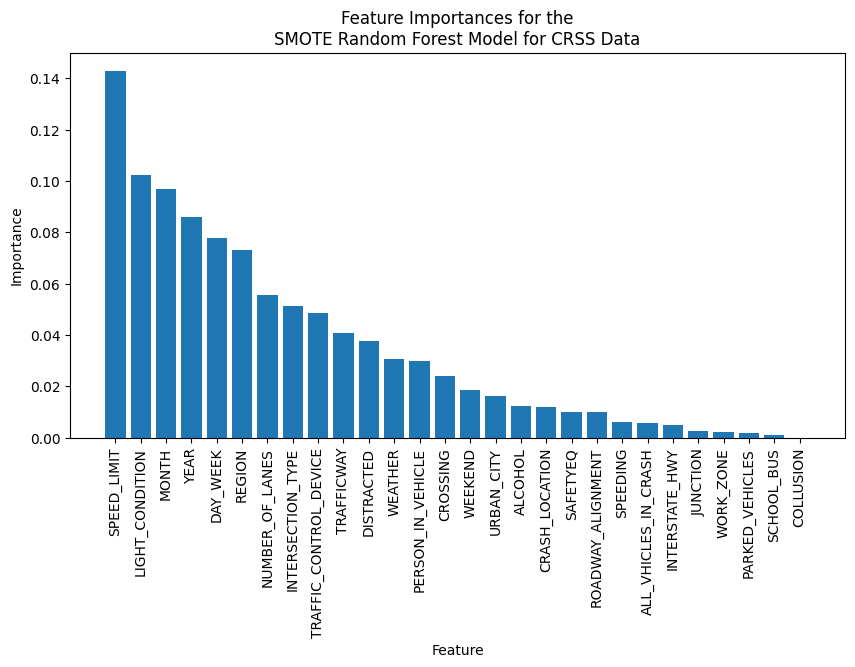

In [114]:
impts = best_rf_model.feature_importances_
idxs = np.argsort(impts)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances for the\nSMOTE Random Forest Model for CRSS Data")
plt.bar(range(len(impts)), impts[idxs], align="center")
plt.xticks(range(len(impts)), [feature_names[i] for i in idxs], rotation=90)  # Make labels vertical
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()



In [115]:
# Find predictions for the test data using the best model
preds_rf = best_rf_model.predict(X_test_scaled_df)

# Find the test accuracy
acc_rf = accuracy_score(y_test, preds_rf)
print("Best SMOTE Random Forest Model's Test Accuracy:", acc_rf)

Best SMOTE Random Forest Model's Test Accuracy: 0.7542458992596893


In [116]:
print("Classification Report SMOTE Random Forest Model:\n")
print(classification_report(y_test, preds_rf))


Classification Report SMOTE Random Forest Model:

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      5304
           1       0.31      0.11      0.16      1263
           2       0.34      0.29      0.31       322

    accuracy                           0.75      6889
   macro avg       0.48      0.44      0.45      6889
weighted avg       0.69      0.75      0.71      6889



In [120]:
conf_mat_rf = confusion_matrix(y_test, preds_rf)

In [121]:
print(conf_mat_rf)

[[5338    0    0]
 [1217    0    0]
 [ 334    0    0]]


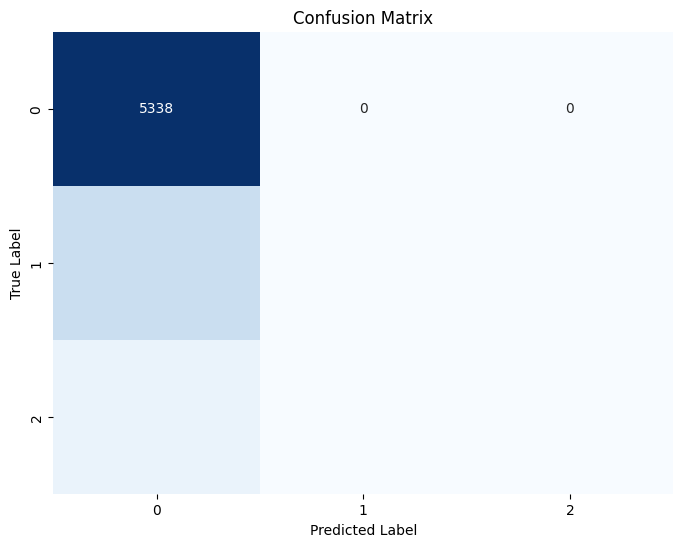

In [122]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# SMOTE FFNN Model:

In [ ]:
def train_best_nn_model(X_train_smote, y_train_smote, X_test, y_test, inp_shp, num_epochs=50, batch_size=32):
    
    model_file = "smote_best_model_nn.h5"
    
    if os.path.exists(model_file):
        print("Loading a neural network")
        best_nn_model = load_model(model_file)
        # Accessing model configuration:
        optimizer_config = best_nn_model.optimizer.get_config()
        print("Optimizer:", optimizer_config)
    else:
        nn_model = Sequential([
            Dense(32, activation='relu', input_shape=(inp_shp,)),
            BatchNormalization(),
            Dense(3, activation='softmax') # 3 possible output class values of 0, 1, or 2
        ])
        
        nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        early_stop_monitor = EarlyStopping(
            monitor='val_loss',
            patience=5, # Stop training when no improvement in validation loss for 5 consecutive epochs
            verbose=1
        )

        nn_model.fit(X_train_smote, y_train_smote, epochs=num_epochs, batch_size=batch_size, 
                     validation_split=0.2, callbacks=[early_stop_monitor])

        nn_model.save(model_file)
        print("Saved a neural network model to file.")

        best_nn_model = nn_model
        optimizer_config = best_nn_model.optimizer.get_config()

    return best_nn_model, optimizer_config


In [124]:
# Call the function
best_nn_model, optimizer_config = train_best_nn_model(X_train_smote, y_train_smote, X_test_scaled_df, y_test, inp_shp=28)

Epoch 1/50
1204/1204 [==============================] - 2s 1ms/step - loss: 0.9249 - accuracy: 0.5320 - val_loss: 1.2701 - val_accuracy: 0.3542
Epoch 2/50
1204/1204 [==============================] - 1s 1ms/step - loss: 0.8519 - accuracy: 0.5718 - val_loss: 1.1396 - val_accuracy: 0.4474
Epoch 3/50
1204/1204 [==============================] - 1s 1ms/step - loss: 0.8350 - accuracy: 0.5834 - val_loss: 1.1453 - val_accuracy: 0.4323
Epoch 4/50
1204/1204 [==============================] - 1s 1ms/step - loss: 0.8234 - accuracy: 0.5877 - val_loss: 1.0374 - val_accuracy: 0.5334
Epoch 5/50
1204/1204 [==============================] - 1s 1ms/step - loss: 0.8156 - accuracy: 0.5953 - val_loss: 1.0134 - val_accuracy: 0.5324
Epoch 6/50
1204/1204 [==============================] - 1s 1ms/step - loss: 0.8068 - accuracy: 0.6033 - val_loss: 0.9797 - val_accuracy: 0.5613
Epoch 7/50
1204/1204 [==============================] - 1s 1ms/step - loss: 0.8046 - accuracy: 0.6002 - val_loss: 0.9445 - val_accuracy:

In [126]:
preds_nn_prob = best_nn_model.predict(X_test_scaled_df)

# Change probabilities to labels
preds_nn = np.argmax(preds_nn_prob, axis=1)

acc_nn = accuracy_score(y_test, preds_nn)
print("SMOTE Neural Network Test Accuracy:", acc_nn)


216/216 [==============================] - 0s 773us/step
SMOTE Neural Network Test Accuracy: 0.6236028451154013


In [127]:
nn_classif_report = classification_report(y_test, preds_nn)
print("Classification Report for the SMOTE Feed Forward Neural Network Model:")
print(nn_classif_report)

Classification Report for the SMOTE Feed Forward Neural Network Model:
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      5338
           1       0.25      0.45      0.32      1217
           2       0.25      0.30      0.28       334

    accuracy                           0.62      6889
   macro avg       0.45      0.48      0.45      6889
weighted avg       0.72      0.62      0.66      6889



In [128]:
best_nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                928       
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,155
Trainable params: 1,091
Non-trainable params: 64
_________________________________________________________________


In [129]:
conf_mat_nn = confusion_matrix(y_test, preds_nn)

In [130]:
print(conf_mat_nn)

[[3644 1508  186]
 [ 556  551  110]
 [  57  176  101]]


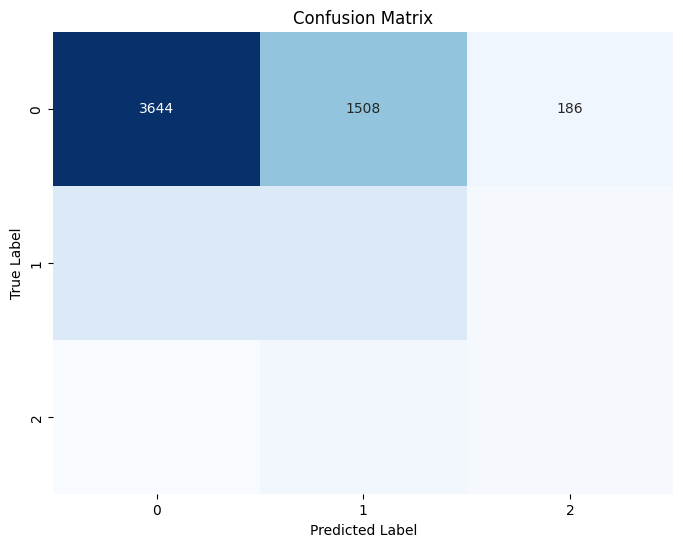

In [131]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_nn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
